＃竹中ウェルネス)


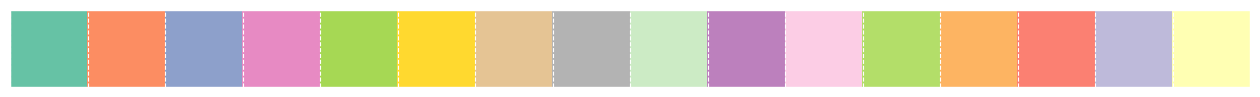

In [45]:
import os
import optuna
import math
import jpholiday
import copy
from datetime import datetime, timedelta
from typing import Union, Literal
import plotly.express as px
import plotly.graph_objects as go
from prettytable import PrettyTable
from pylab import rcParams
from matplotlib import font_manager
import warnings
import seaborn.objects as so
import seaborn as sns
import random
from IPython.display import display, HTML
from pmdarima import arima
from pmdarima import utils
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import matplotlib.patheffects as patheffects
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost')
# Filter out specific UserWarnings related to set_ticklabels
warnings.filterwarnings('ignore', category=UserWarning, module='plot_utils',
                        message='.*set_ticklabels.*should only be used with a fixed number of ticks.*')
# from logic import predict_cop,svr_predict,train_RA_8,train_TR_1,train_TR_2,train_TR_3
# graph setting
%matplotlib inline
sns.set_style("darkgrid", {'grid.linestyle': '--'})
sns.set_context("paper", 1.5, {"lines.linewidth": 1.5})
sns.set_palette("Set2")
current_palette = list(sns.color_palette(
    "Set2", n_colors=8) + sns.color_palette("Set3_r", n_colors=8))
sns.set_palette(current_palette)
sns.palplot(current_palette)

# 凡例の色を黒に設定
sns.set(rc={"legend.facecolor": "white",
            "legend.edgecolor": "#c7c5c7",
            "legend.labelcolor": "black"})

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic',
                               'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
rcParams['axes.axisbelow'] = True

display(HTML("<style>.container { width:100% !important; }</style>"))

In [46]:
# set current working directory dynamically
os.chdir("..")
print(os.getcwd())

/Users/hussain/Menteru-Github/takenaka-wellness-project


In [47]:
from prediction_module.utilities.score_utils import *

from prediction_module.utilities.data_preprocess import *
from prediction_module.utilities.models import XGBoostModel
from prediction_module.utilities.plot_utils import *
from data_module.config.utils import (
    get_path_from_config,
    get_path_from_config_for_outside_base_folder,
)

## データセットファイルを取得


### 初期設定


In [48]:
CASE_NAME = "v.06.1.1"  # メインケース
building_name = "4F西"
floor = 4
direction = "西"
display(building_name[0], building_name[2])

'4'

'西'

## Model Build & Train


- true: Cold_demand
- pred_diff: Cold_demand_diff_24
- y0*base: Cold_demand_shift*-24
- pred: pred_diff+y0_base


ウェルネス空調制御消費電力量予測


In [49]:
data_train = pd.read_csv(
    get_path_from_config_for_outside_base_folder("train_data_path"),
    encoding="cp932",
)  # 前処理後のデータ
data_predict = pd.read_csv(
    get_path_from_config_for_outside_base_folder("test_data_path"),
    encoding="cp932",
)  # 前処理後のデータ

dict_column_name = pd.read_excel(
    get_path_from_config("dict_column_name_path"),
    sheet_name=None,
)
dict_column_name_experiment = pd.read_excel(
    get_path_from_config("dict_column_name_experiment_path"),
    sheet_name=None,
    index_col="除くカラム",
)
master_data = pd.read_excel(
    get_path_from_config_for_outside_base_folder("master_data_path"),
    sheet_name=None,
)

In [50]:
# object型となっているdatetimeとdateをdatetime型に変更
data_train["datetime"] = pd.to_datetime(data_train["datetime"])
data_train["date"] = pd.to_datetime(data_train["date"])
data_predict["datetime"] = pd.to_datetime(data_predict["datetime"])
data_predict["date"] = pd.to_datetime(data_predict["date"])

In [66]:
# 調べたい系統を検索
# ここのパラメータをいじって精度検証
floor_direction_name = str(floor) + "F" + direction
eval_metric = "rmse"
x = 23  # 何番目の組み合わせ(どのカラムを抜くか)を設定 元：23
column_name = dict_column_name[
    floor_direction_name
]  # 系統別で用いられる説明変数と目的変数のカラム名

In [67]:
# 精度検証のための表を取得
df_column_name = dict_column_name_experiment[floor_direction_name]
used_column_list = []  # 精度検証で選ばれた説明変数に使うカラム名
delete_column = []  # 目的変数用のカラム名と不要なカラム名
# df_column_name.iloc[〇,k]の○に設定(どのカラムを抜くか)を決定
for k in range(len(df_column_name.columns)):
    if df_column_name.iloc[x, k] == 1:
        used_column_list.append(df_column_name.columns.tolist()[k])
    else:
        if df_column_name.iloc[x, k] == 2:
            delete_column.append(df_column_name.columns.tolist()[k])
display(used_column_list)

['外気温度予測値_℃',
 '外気湿度予測値_RH',
 'fiscal_year',
 'month',
 'hour',
 'is_holiday',
 '設定温度_C_4F執務室_西',
 '湿球温度_C',
 'System_ON_OFF_4F_西',
 '温度差(室内-設定)_C_4F_西',
 '温度差(外気-設定)_C_4F_西',
 'Operation_Mode_4F_西',
 'DayType_土',
 'DayType_日',
 'DayType_月',
 'DayType_木',
 'DayType_水',
 'DayType_火',
 'DayType_金']

精度検証用  
学習期間 2022 年 4 月～ 2023 年 3 月  
テスト期間 2023 年 4 月～ 2024 年 3 月


精度検証用  
学習期間 2021 年 4 月～ 2022 年 3 月，2023 年 4 月～ 2024 年 3 月  
テスト期間 2022 年 4 月～ 2023 年 3 月


## `BEFORE` Hyperparameter Tuning (ハイパーパラメータチューニングの`前`)


In [69]:
def plot_scatter_formatted(score_evaluator_val, ticks, feature_name):
    fig = plt.figure(figsize=(6, 10))
    ax2 = fig.add_subplot(1, 1, 1)
    xticks = ticks
    plot_scatter(
        ax2,
        score_evaluator_val.df,
        x="true",
        y="pred",
        xlabel="実績値",
        ylabel="予測値",
        xticks=xticks,
        alpha=0.5,
        title="val",
        color="tab:blue",
    )
    ax2.set_xlabel(f"実績値")
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks, fontsize=16)
    ax2.set_ylabel(f"予測値")
    ax2.set_yticks(xticks)
    ax2.set_yticklabels(xticks, fontsize=16)
    ax2.set_title(f"{feature_name} ", fontsize=18)
    fig.tight_layout()

In [70]:
# モデルの学習
input_features = used_column_list
output_features = "総消費電力量"
model = XGBoostModel(input_features, output_features)
X_train, y_train_diff, X_val, y_val_diff = model.preprocess(
    prepared_data_train, prepared_data_test
)
model.train(X_train, y_train_diff)
# display(y_train_diff.values)

# モデルの予測
# y_train_y0_base = train["Cold_demand_shift_-24"].values
# y_val_y0_base = valid["Cold_demand_shift_-24"].values
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

# y_train = train["Cold_demand"].values
# y_val = valid["Cold_demand"].values

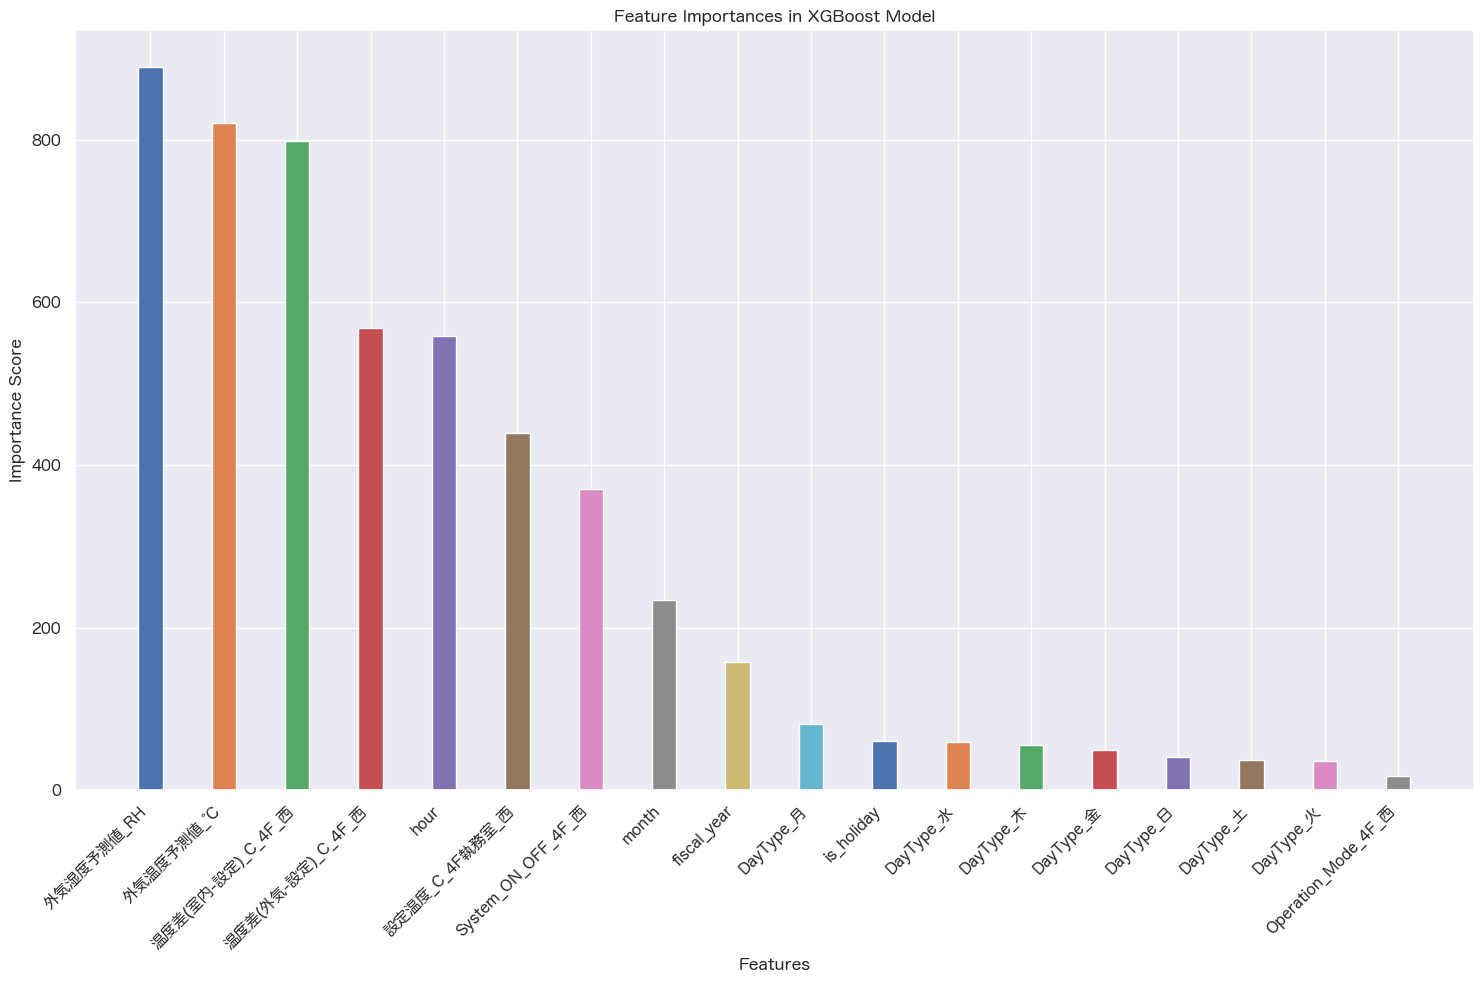

In [71]:
# 　特徴量の重要度をプロット
plot_feature_importance(model)

==train==
MAE = 0.40925347425258957
RMSE = 0.5513196515993141
MAPE(%) --eps=0.001 --exclude_under=None = 13478.942171043032
MAPE(%) --eps=0 --exclude_under=2 = 20.18600409177811
==valid==
MAE = 0.6603982656788897
RMSE = 1.128917677959759
MAPE(%) --eps=0.001 --exclude_under=None = 16807.68026504246
MAPE(%) --eps=0 --exclude_under=2 = 44.577943775472235


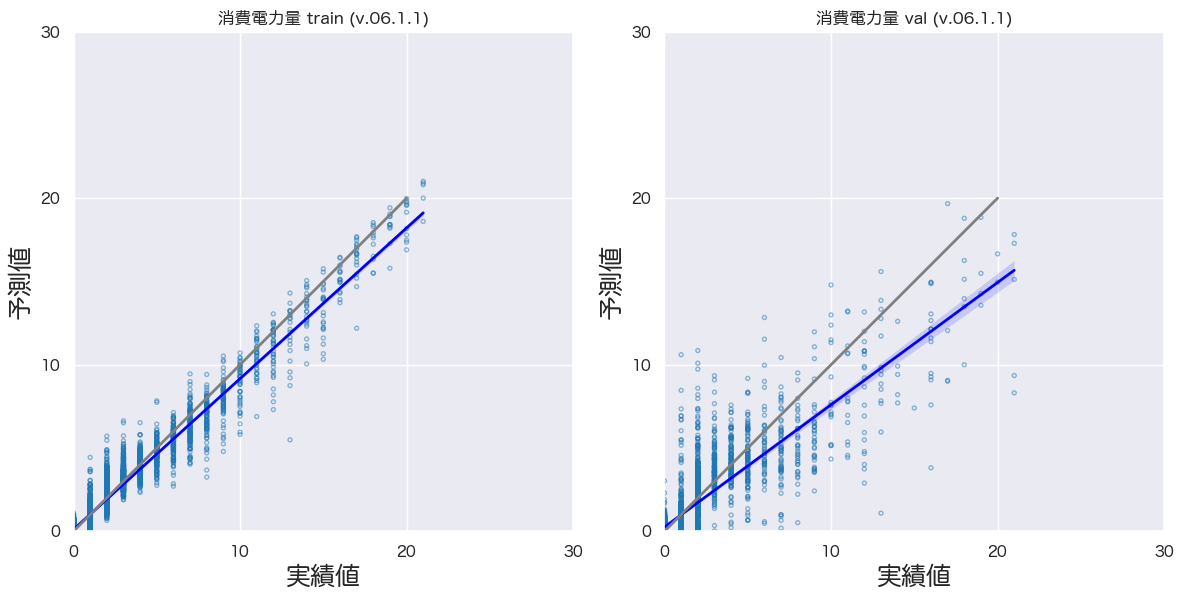

In [72]:
X_train = pd.DataFrame(X_train, columns=input_features)
X_val = pd.DataFrame(X_val, columns=input_features)
# 予測結果の評価
print("==train==")
score_evaluator_train = ScoreEvaluator(X_train, y_train_diff, pred_train)
score_evaluator_train.evaluate()

print("==valid==")
score_evaluator_val = ScoreEvaluator(X_val, y_val_diff, pred_val)
score_evaluator_val.evaluate()

ticks = np.arange(0, 31, 10)

feature_name = "消費電力量"
plot_scatters_train_valid(
    score_evaluator_train, score_evaluator_val, ticks, CASE_NAME, feature_name
)

メモ  
元：MAE=0.811 RMSE=1.675  
ランダム：MAE=0.5447 RMSE=0.929  
2023 年除去：MAE=0.829 RMSE=1.623  
低負荷レコード： MAE=0.927 RMSE=2.418


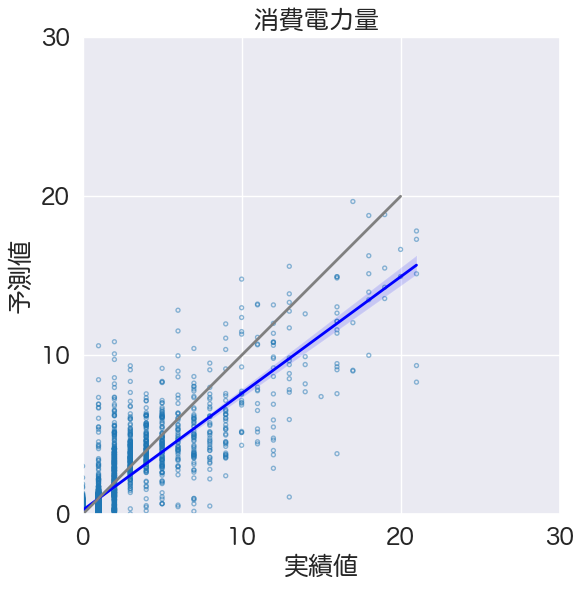

In [73]:
unit = "(GJ)"
plot_scatter_formatted(score_evaluator_val, ticks, feature_name)

==train==
MAE = 0.35163955785795564
RMSE = 0.5001679941691236
MAPE(%) --eps=0.001 --exclude_under=None = 11273.599663417343
MAPE(%) --eps=0 --exclude_under=2 = 17.34261770831803
==valid==
MAE = 0.6472819814109115
RMSE = 1.1068691739748424
MAPE(%) --eps=0.001 --exclude_under=None = 16486.427022421016
MAPE(%) --eps=0 --exclude_under=2 = 43.44608229149179


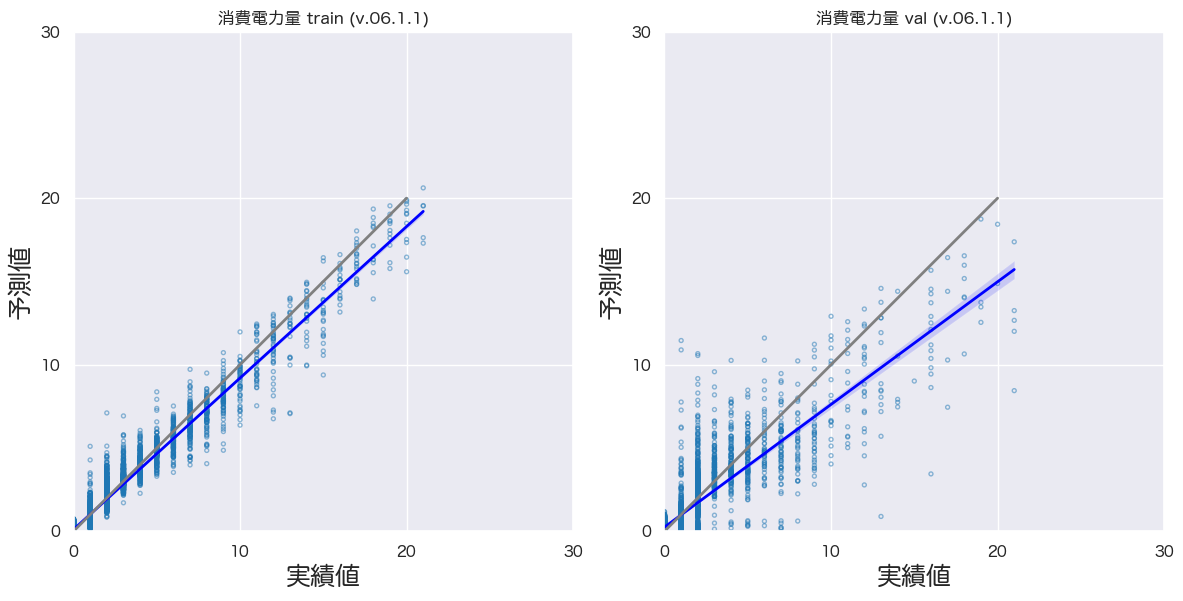

In [ ]:
data_1 = pd.read_csv("/Users/hussain/Menteru-Github/takenaka-wellness-project/00_Data/03_Output/result_df_4F東_test.csv"
                             ,encoding="cp932")

X_train = pd.DataFrame(X_train, columns=input_features)
X_val = pd.DataFrame(X_val, columns=input_features)
# 予測結果の評価
print("==train==")
score_evaluator_train = ScoreEvaluator(X_train, y_train_diff, pred_train)
score_evaluator_train.evaluate()

print("==valid==")
score_evaluator_val = ScoreEvaluator(X_val, y_val_diff, pred_val)
score_evaluator_val.evaluate()

ticks = np.arange(0, 31, 10)

feature_name = "消費電力量"
plot_scatters_train_valid(
    score_evaluator_train, score_evaluator_val, ticks, CASE_NAME, feature_name
)

## Plot Results (グラフを作成)


In [83]:
display(len(pred_val.tolist()))
result_df = pd.DataFrame(data=pred_val.tolist(), columns=["予測"])
result_df["正解"] = y_val_diff.tolist()
result_df["時間"] = datetime_data
result_df["ON/OFF"] = prepared_data_test[
    "System_ON_OFF_{}F_{}".format(floor, direction)
].tolist()
# result_df["室外機消費電力量_kWh_{}F_{}".format(floor,direction)]=prepared_data_test["室外機消費電力量_kWh_{}F_{}".format(floor,direction)]
result_df["外気温度予測値_℃"] = prepared_data_test["外気温度予測値_℃"].tolist()
# 後処理
# OFFならば予測を0，予測が負ならば0に変換

for k in range(len(result_df)):
    if result_df.loc[k, "ON/OFF"] == 0:
        result_df.loc[k, "予測"] = 0
    if result_df.loc[k, "予測"] < 0:
        result_df.loc[k, "予測"] = 0
display(result_df.sort_values("時間"))

6840

,予測,正解,時間,ON/OFF,外気温度予測値_℃
0,0.000000,1.0,2021-04-01 03:00:00,0,9.75
1,6.197897,1.0,2021-04-01 06:00:00,1,9.70
2,0.000000,0.0,2021-04-01 11:00:00,0,18.40
3,0.000000,1.0,2021-04-01 12:00:00,0,19.60
4,2.511345,1.0,2021-04-01 14:00:00,1,20.60
...,...,...,...,...,...
6835,0.000000,0.0,2024-03-31 16:00:00,0,22.20
6836,0.000000,0.0,2024-03-31 18:00:00,0,19.00
6837,0.000000,0.0,2024-03-31 19:00:00,0,17.55
6838,0.000000,1.0,2024-03-31 20:00:00,0,16.50


In [84]:
display(result_df.corr())

,予測,正解,時間,ON/OFF,外気温度予測値_℃
予測,1.000000,0.856935,0.018536,0.835671,0.125482
正解,0.856935,1.000000,0.015654,0.683089,0.101847
時間,0.018536,0.015654,1.000000,-0.009876,-0.162365
ON/OFF,0.835671,0.683089,-0.009876,1.000000,0.225280
外気温度予測値_℃,0.125482,0.101847,-0.162365,0.225280,1.000000


In [85]:
# data_1 = result_df.copy()
data_1 = pd.read_csv("/Users/hussain/Menteru-Github/takenaka-wellness-project/00_Data/03_Output/result_df_4F東_test.csv"
                             ,encoding="cp932")
data_2 = pd.read_csv(
    "/Users/hussain/Menteru-Github/takenaka-wellness-project/00_Data/01_PreProcessData/preprocessed_data_for_train.csv",
    encoding="cp932",
)
objective_data = (
    data_2[delete_column[0]] + data_2[delete_column[1]].tolist()
)  # 学習データの目的変数
data_2["総消費電力量"] = objective_data
# データの前処理
start_date = "2023-04-01"
end_date = "2024-04-01"


data_2 = data_2[(data_2["datetime"] >= start_date) & (data_2["datetime"] <= end_date)]
data_2.set_index("datetime", inplace=True)
data_2 = data_2.drop(data_2.columns[0], axis=1)
data_2.index.name = None
display(len(data_2))

data_1["時間"] = pd.to_datetime(data_1["時間"])
data_1.set_index("時間", inplace=True)
# data_1 = data_1.drop(data_1.columns[0], axis=1)
data_1.index.name = None
display(data_1)

# データの結合
data_2.index = pd.to_datetime(data_2.index)
data_1.index = pd.to_datetime(data_1.index)

main_df = pd.concat([data_2, data_1], axis=1)
main_df = main_df.dropna(how="all")

8754

,Unnamed: 0,予測,正解,ON/OFF,外気温度予測値_℃
2021-04-01 04:00:00,0,0.000000,1.0,0,9.75
2021-04-01 07:00:00,1,0.000000,0.0,0,10.35
2021-04-01 08:00:00,2,2.757294,1.0,1,12.10
2021-04-01 12:00:00,3,0.000000,0.0,0,19.60
2021-04-01 14:00:00,4,4.408327,1.0,1,20.60
...,...,...,...,...,...
2024-03-31 14:00:00,6835,0.000000,0.0,0,23.30
2024-03-31 15:00:00,6836,0.000000,0.0,0,22.65
2024-03-31 18:00:00,6837,0.000000,0.0,0,19.00
2024-03-31 20:00:00,6838,0.000000,0.0,0,16.50


In [86]:
# display(main_df)
display(main_df[(main_df["date"] >= start_date)])
display(
    main_df[(main_df["date"] >= start_date)]["予測"].isnull().sum()
    / len(main_df[(main_df["date"] >= start_date)])
)

,空調負荷予測_kWh,外気温度予測値_℃,外気湿度予測値_RH,室内機消費電力量_kWh_4F_西,室内機消費電力量_kWh_4F_東,室内機消費電力量_kWh_5F_西,室内機消費電力量_kWh_5F_東,室外機消費電力量_kWh_4F_西,室外機消費電力量_kWh_4F_東,室外機消費電力量_kWh_5F_西,...,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東,DayType,総消費電力量,Unnamed: 0,予測,正解,ON/OFF,外気温度予測値_℃
2023-04-01 00:00:00,0.00,9.70,96.80,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,土,1.0,NaN,NaN,NaN,NaN,NaN
2023-04-01 01:00:00,0.00,8.95,97.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN,NaN
2023-04-01 02:00:00,3.45,8.45,96.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,土,1.0,NaN,NaN,NaN,NaN,NaN
2023-04-01 03:00:00,0.00,8.10,97.55,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,土,1.0,4230.0,0.0,0.0,0.0,8.1
2023-04-01 04:00:00,0.00,7.35,99.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 19:00:00,15.10,17.55,79.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN,NaN
2024-03-31 20:00:00,0.00,16.50,82.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,日,1.0,6838.0,0.0,0.0,0.0,16.5
2024-03-31 21:00:00,742.80,15.90,81.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN,NaN
2024-03-31 22:00:00,156.45,15.30,83.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN,NaN


0.7018505825908157

In [87]:
display(main_df.columns)

Index(['空調負荷予測_kWh', '外気温度予測値_℃', '外気湿度予測値_RH', '室内機消費電力量_kWh_4F_西',
       '室内機消費電力量_kWh_4F_東', '室内機消費電力量_kWh_5F_西', '室内機消費電力量_kWh_5F_東',
       '室外機消費電力量_kWh_4F_西', '室外機消費電力量_kWh_4F_東', '室外機消費電力量_kWh_5F_西',
       '室外機消費電力量_kWh_5F_東', 'date', 'fiscal_year', 'month', 'hour',
       'is_holiday', '室内相対湿度_RH_4F', '室内相対湿度_RH_5F', '室内温度_C_4F執務室_西',
       '室内温度_C_4F執務室_東', '室内温度_C_5F執務室_西', '室内温度_C_5F執務室_東', '設定温度_C_4F執務室_西',
       '設定温度_C_4F執務室_東', '設定温度_C_5F執務室_西', '設定温度_C_5F執務室_東', '湿球温度_C',
       'System_ON_OFF_4F_西', 'System_ON_OFF_4F_東', 'System_ON_OFF_5F_西',
       'System_ON_OFF_5F_東', '温度差(外気-室内)_C_4F_西', '温度差(外気-室内)_C_4F_東',
       '温度差(外気-室内)_C_5F_西', '温度差(外気-室内)_C_5F_東', '温度差(室内-設定)_C_4F_西',
       '温度差(室内-設定)_C_4F_東', '温度差(室内-設定)_C_5F_西', '温度差(室内-設定)_C_5F_東',
       '温度差(外気-設定)_C_4F_西', '温度差(外気-設定)_C_4F_東', '温度差(外気-設定)_C_5F_西',
       '温度差(外気-設定)_C_5F_東', 'Operation_Mode_4F_西', 'Operation_Mode_4F_東',
       'Operation_Mode_5F_西', 'Operation_Mode_5F_東', 'DayType', '総消費電力量',


In [88]:
main_df.drop(columns=["Unnamed: 0"], inplace=True)
main_df.head()
main_df.to_csv("main_df.csv", index=False, encoding="cp932")

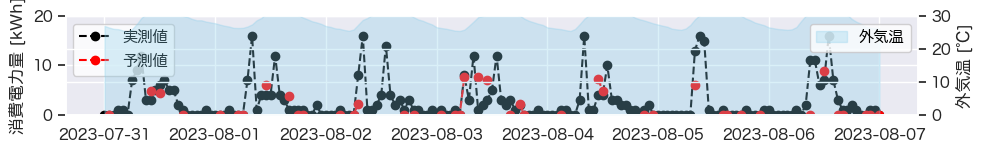

In [89]:
# 時刻別予測結果
# 8月5日から8月15日までのデータをフィルタリング
start_date = "2023-07-31"
end_date = "2023-08-07"
filtered_df = main_df[(main_df.index >= start_date) & (main_df.index <= end_date)]
# display(filtered_df)

# プロット作成
fig, ax1 = plt.subplots(figsize=(10, 1.7))

# 第1軸: 実測値と予測値の線グラフ
ax1.plot(
    filtered_df.index,
    filtered_df.iloc[:, 48],
    color="black",
    marker="o",
    linestyle="--",
    label="実測値",
)
ax1.plot(
    filtered_df.index,
    filtered_df.iloc[:, 49],
    color="red",
    marker="o",
    linestyle="--",
    label="予測値",
)
# ax1.fill_between(filtered_df.index, filtered_df.iloc[:, 48], color='grey', alpha=0.3, label='実測値')
# ax1.set_xlabel('日付')
ax1.set_ylabel("消費電力量 [kWh]")
ax1.grid(True)
ax1.legend(loc="upper left")
ax1.set_ylim(0, 20)

# 第2軸: 外気温の面グラフ
ax2 = ax1.twinx()
ax2.fill_between(
    filtered_df.index,
    filtered_df.iloc[:, 1],
    color="skyblue",
    alpha=0.3,
    label="外気温",
)
ax2.set_ylabel("外気温 [℃]")
ax2.legend(loc="upper right")
ax2.set_ylim(0, 30)

# プロットの表示
plt.tight_layout()
plt.show()
# plt.savefig('scatter_plot_7.png', dpi=300, bbox_inches='tight')

In [90]:
import jpholiday

result_4F_west = pd.read_csv("/Users/hussain/Menteru-Github/takenaka-wellness-project/00_Data/03_Output/result_df_4F西_test.csv"
                             ,encoding="cp932")
result_4F_west["時間"] = pd.to_datetime(result_4F_west["時間"])
result_4F_west.set_index("時間", inplace=True)
# Mark as holiday if the date is a national holiday or a weekend (Saturday=5, Sunday=6)
result_4F_west["is_holiday"] = result_4F_west.index.map(lambda x: jpholiday.is_holiday(x) or x.weekday() >= 5)
# Convert boolean to integer (True -> 1, False -> 0)
result_4F_west["is_holiday"] = result_4F_west["is_holiday"].astype(int)

result_4F_west.head()

# add column for holidy or not usi

,Unnamed: 0,予測,正解,ON/OFF,外気温度予測値_℃,is_holiday
時間,,,,,,
2021-04-01 09:00:00,0,0.000000,0.0,0,14.65,0
2021-04-01 13:00:00,1,0.000000,1.0,0,20.30,0
2021-04-01 20:00:00,2,0.000000,1.0,0,14.80,0
2021-04-01 21:00:00,3,2.891495,2.0,1,14.05,0
2021-04-01 22:00:00,4,0.000000,1.0,0,13.85,0


In [91]:
# 休日(is_holiday=1)のデータをフィルタリング
holiday_df = result_4F_west[result_4F_west["is_holiday"] == 1]
# 平日(is_holiday=0)のデータをフィルタリング
weekday_df = result_4F_west[result_4F_west["is_holiday"] == 0]

In [ ]:
main_df

In [102]:
main_df.head()

,空調負荷予測_kWh,外気温度予測値_℃,外気湿度予測値_RH,室内機消費電力量_kWh_4F_西,室内機消費電力量_kWh_4F_東,室内機消費電力量_kWh_5F_西,室内機消費電力量_kWh_5F_東,室外機消費電力量_kWh_4F_西,室外機消費電力量_kWh_4F_東,室外機消費電力量_kWh_5F_西,...,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東,DayType,総消費電力量,予測,正解,ON/OFF,外気温度予測値_℃
2021-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.0,0.0,9.75
2021-04-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,10.35
2021-04-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.757294,1.0,1.0,12.10
2021-04-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,19.60
2021-04-01 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.408327,1.0,1.0,20.60


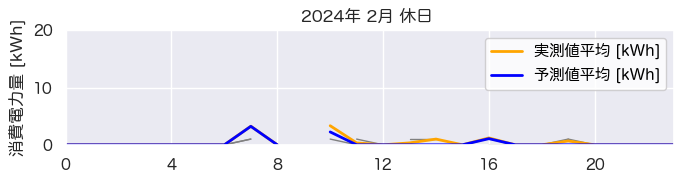

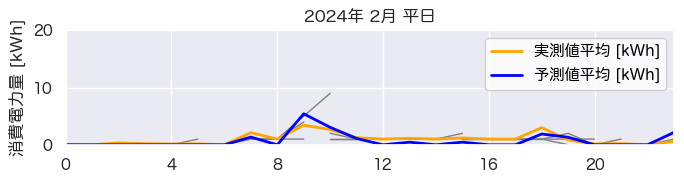

In [111]:
year = 2024
#予測値の月別平均比較
for month in [2]:
    # 月ごとのデータをフィルタリング
    month_df = main_df[(main_df.index.month == month) & (main_df.index.year == year)]

    # "正解"と"予測"の列を選択
    correct_values = month_df.filter(like='正解')
    predicted_values = month_df['予測']  # "予測"カラムが1つだけと仮定

    # 休日(is_holiday=1)のデータをフィルタリング
    holiday_df = month_df[month_df['is_holiday'] == 1]
    # 平日(is_holiday=0)のデータをフィルタリング
    weekday_df = month_df[month_df['is_holiday'] == 0]

    # 各日ごとのデータをプロット
    def plot_data(df, title, filename):
        correct_values = df.filter(like='正解')
        predicted_values = df['予測']
        plt.figure(figsize=(7, 2))
        days_in_month = correct_values.index.day.unique()

        # 各日ごとのデータを灰色の線でプロット
        for day in days_in_month:
            daily_data = correct_values[correct_values.index.day == day]
            plt.plot(daily_data.index.hour, daily_data.mean(axis=1), color='gray', linewidth=1)

        # "正解"の月平均をオレンジ色でプロット
        correct_hourly_mean = correct_values.groupby(correct_values.index.hour).mean()
        plt.plot(correct_hourly_mean.index, correct_hourly_mean.mean(axis=1), color='orange', linewidth=2,
                 label='実測値平均 [kWh]')

        # "予測"の月平均を青色でプロット
        predicted_hourly_mean = predicted_values.groupby(predicted_values.index.hour).mean()
        plt.plot(predicted_hourly_mean.index, predicted_hourly_mean, color='blue', linewidth=2, label='予測値平均 [kWh]')

        # グラフのラベルとタイトル
        #plt.xlabel('時刻')
        plt.ylabel('消費電力量 [kWh]')
        plt.xticks(range(0, 23, 4))
        plt.title(title)
        plt.grid(True)
        plt.ylim(0, 20)
        plt.xlim(0, 23)

        # 凡例を追加
        plt.legend(loc='upper right')

        # 図を保存
        #plt.savefig(filename, dpi=300, bbox_inches='tight')

        # プロットの表示
        plt.tight_layout()
        plt.show()

# 休日のデータをプロットし、保存
plot_data(holiday_df, title=f"{year}年 {month}月 休日 ", filename=f"{year}年{month}月_休日.png")

# 平日のデータをプロットし、保存
plot_data(weekday_df, title=f"{year}年 {month}月 平日", filename=f"{year}年{month}月_平日.png")

In [94]:
# # holiday_df と weekday_df のデータを保存

holiday_df.to_csv(
    f"{month}月_休日_{floor}{direction}.csv", index=False, encoding="cp932"
)
weekday_df.to_csv(
    f"{month}月_平日_{floor}{direction}.csv", index=False, encoding="cp932"
)

In [95]:
valid_ = prepared_data_test.copy()
display(type(datetime_data))
display(type(date_data))
valid_["datetime"] = datetime_data
valid_["date"] = str(date_data)
valid_["true"] = y_val_diff
valid_["pred"] = pred_val
display(valid_.iloc[:, -5:])

list

list

,総消費電力量,datetime,date,true,pred
3,1.0,2021-04-01 03:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,0.588892
6,1.0,2021-04-01 06:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,6.197897
11,0.0,2021-04-01 11:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.507182
12,1.0,2021-04-01 12:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,0.359977
14,1.0,2021-04-01 14:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,2.511345
...,...,...,...,...,...
22791,0.0,2024-03-31 16:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.239261
22793,0.0,2024-03-31 18:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.446345
22794,0.0,2024-03-31 19:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",0.0,0.382406
22795,1.0,2024-03-31 20:00:00,"[Timestamp('2021-04-01 00:00:00'), Timestamp('...",1.0,0.017536


In [96]:
graph_params = {
    1: dict(date="2023年5月", specific_season_name="May_week_1"),
    2: dict(date="2023年8月", specific_season_name="Aug_week_1"),
    3: dict(date="2023年11月", specific_season_name="Nov_week_1"),
    4: dict(date="2024年2月", specific_season_name="Feb_week_1"),
}

In [97]:
def plot_mae_mape_by_month(df, feature_name, y_limits):
    fig, ax = plt.subplots(figsize=(16, 4))
    xticks = range(1, 13)

    # Plot MAE
    plot1 = ax.plot(
        df["month"],
        df["mean_absolute_error"],
        marker="o",
        color="tab:blue",
        linestyle="--",
        label="MAE",
    )

    # Create a second y-axis for MAPE
    ax2 = ax.twinx()
    plot2 = ax2.plot(
        df["month"],
        df["mean_absolute_percentage_error"],
        marker="s",
        color="tab:orange",
        linestyle="--",
        label="MAPE",
    )

    # Format and settings
    ax.set_xticks(xticks)
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(False)
    ax.set_title(f"{feature_name} 評価期間: 2023-04-01 ～2024-03-31 ")

    # Combine legends from both plots
    legends = plot1 + plot2
    labels = [l.get_label() for l in legends]
    ax.legend(legends, labels, loc=0)

    # Set y-axis limits
    ax.set_ylim(y_limits[0])
    ax2.set_ylim(y_limits[1])

    ax.set_xlabel("Month")
    ax.set_ylabel("MAE")
    ax2.set_ylabel("MAPE", labelpad=20, rotation=270)

    plt.show()


def plot_mae_rmse_by_month(df, feature_name, y_limits):
    fig, ax = plt.subplots(figsize=(16, 4))
    xticks = range(1, 13)

    a = [float("{:.2g}".format(df["mean_absolute_error"][i])) for i in range(len(df))]
    df["MAE"] = a
    a = [
        float("{:.4g}".format(df["root_mean_squared_error"][i] * 100))
        for i in range(len(df))
    ]
    df["RMSE"] = a

    # Plot MAE
    plot1 = ax.plot(
        df["month"],
        df["MAE"],
        marker="o",
        color="tab:blue",
        linestyle="--",
        label="MAE",
    )
    # マーカーに件数表示
    for idx, val in enumerate(df["MAE"].tolist()):  # df["mean_absolute_error"].tolist()
        ax.text(
            df["month"].tolist()[idx],
            df["MAE"].tolist()[idx] - 0.15,
            f"{val:,}",
            ha="center",
            va="bottom",
            path_effects=[
                patheffects.withStroke(
                    linewidth=3, foreground="white", capstyle="round"
                )
            ],
        )

    # Create a second y-axis for RMSE
    ax2 = ax.twinx()
    plot2 = ax2.plot(
        df["month"],
        df["RMSE"],
        marker="s",
        color="tab:orange",
        linestyle="--",
        label="RMSE",
    )

    # マーカーに件数表示
    for idx, val in enumerate(
        df["RMSE"].tolist()
    ):  # df["mean_absolute_error"].tolist()
        ax2.text(
            df["month"].tolist()[idx],
            df["RMSE"].tolist()[idx] + 5,
            f"{val:,}",
            ha="center",
            va="bottom",
            path_effects=[
                patheffects.withStroke(
                    linewidth=3, foreground="white", capstyle="round"
                )
            ],
        )

    # Format and settings
    ax.set_xticks(xticks)
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(False)
    # ax.set_title(f"{feature_name} ")#評価期間: 2023-04-01 ～2024-03-31

    # Combine legends from both plots
    legends = plot1 + plot2
    labels = [l.get_label() for l in legends]
    ax.legend(legends, labels, loc=0)

    # Set y-axis limits
    ax.set_ylim(y_limits[0])
    ax2.set_ylim(y_limits[1])

    ax.set_xlabel("Month")
    ax.set_ylabel("MAE[kWh]")
    ax2.set_ylabel("RMSE[%]", labelpad=20, rotation=270)

    plt.show()

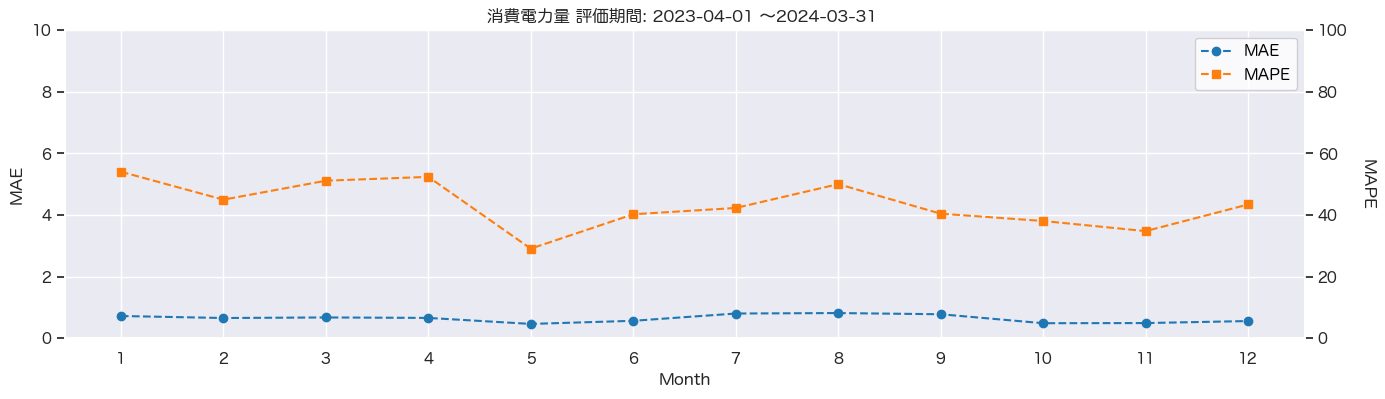

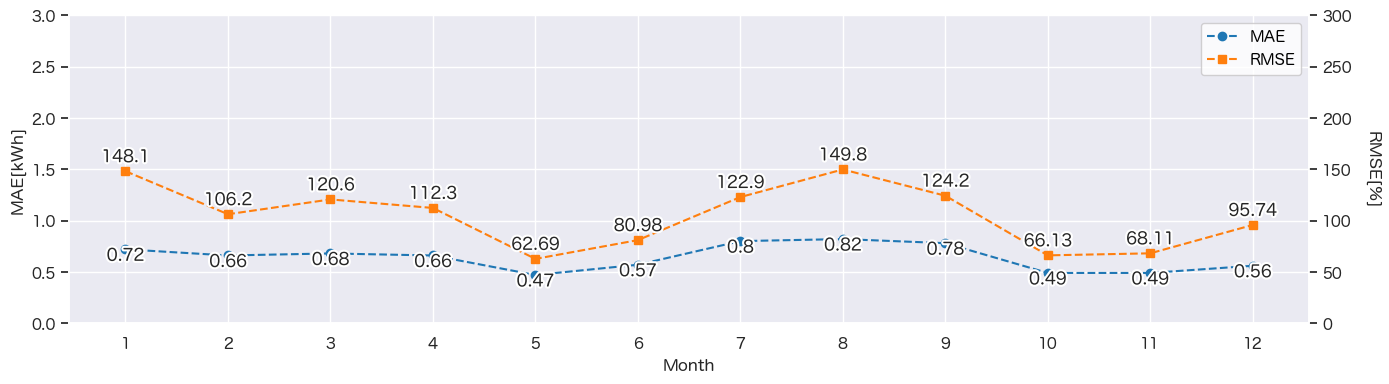

In [98]:
df_scores_month = get_scores_by_month(score_evaluator_val)

plot_mae_mape_by_month(df_scores_month, feature_name, [[0.0, 10.0], [0.0, 100]])
plot_mae_rmse_by_month(df_scores_month, feature_name, [[0.0, 3.0], [0.0, 300.0]])

In [99]:
# df_scores_month のデータを保存

df_scores_month.to_csv(
    f"df_score_months_{floor}{direction}.csv", index=False, encoding="cp932"
)

In [100]:
# --- main_df は datetime 型のインデックスと、"予測"、"正解" を含むカラムがあると仮定 ---
# 例: main_df = pd.read_csv("your_data.csv", parse_dates=["日時"], index_col="日時")

output_filename = f"output_{floor}{direction}.xlsx"
# openpyxlエンジンを使用

month_2023 = [5, 8, 11 ]
year = 2023
with pd.ExcelWriter(output_filename, engine="openpyxl") as writer:
    # 2023年の1月から5月までループ
    for month in month_2023:
        # 現在の月のデータをフィルタリング
        month_df = main_df[
            (main_df.index.year == year) & (main_df.index.month == month)
        ]
        if month_df.empty:
            continue  # データがなければスキップa

        # Separate weekdays and weekends using the datetime index
        # Monday (0) to Friday (4) are weekdays; Saturday (5) and Sunday (6) are weekends.
        weeek_df = month_df[month_df.index.dayofweek < 5]
        weekend_df = month_df[month_df.index.dayofweek >= 5]

        for subset, subset_name in zip([weeek_df, weekend_df], ["平日", "休日"]):
            if subset.empty:
                continue  # データがなければスキップ

            # 予測値の時刻ごとの平均値を計算
            predicted_hourly = subset["予測"].groupby(subset.index.hour).mean()

            # 実測値 ("正解" 列) の時刻ごとの平均値を計算
            # 複数の "正解" 列がある場合は、まず各タイムスタンプでの平均を計算し、その後時間単位で平均を計算
            actual_hourly = (
                subset.filter(like="正解")
                .mean(axis=1)
                .groupby(subset.index.hour)
                .mean()
            )

            # 0〜23時の時間をインデックスとしてDataFrameを作成
            hours = list(range(24))
            df_excel = pd.DataFrame(
                {
                    "時間": [f"{h}:00" for h in hours],
                    "予測の時刻別平均値": [
                        predicted_hourly.get(h, np.nan) for h in hours
                    ],
                    "実測の時刻別平均値": [actual_hourly.get(h, np.nan) for h in hours],
                }
            )
            df_excel.set_index("時間", inplace=True)

            # 各日ごとの実測値（各日の各時刻の値）を追加（NaNも含む）
            unique_days = sorted(subset.index.day.unique())
            for day in unique_days:
                # 各日のデータをフィルタリング
                day_df = subset[subset.index.day == day]
                # 各タイムスタンプでの実測値（"正解" 列の平均）を計算
                daily_series = day_df.filter(like="正解").mean(axis=1)
                # 時刻ごとに平均値を計算
                daily_hourly = daily_series.groupby(day_df.index.hour).mean()
                # 0〜23時すべての時間に対して値を整える（データがない時間はNaN）
                daily_hourly = daily_hourly.reindex(hours)
                # カラム名を「{day}日」として追加
                df_excel[f"{day}日"] = daily_hourly.values

            # 各月のデータをExcelのシートに書き込む（シート名例："2023-01"）
            sheet_name = f"{year}-{month:02d} {subset_name}"
            df_excel.to_excel(writer, sheet_name=sheet_name)

print(f"Excel file '{output_filename}' has been created.")

Excel file 'output_4西.xlsx' has been created.
